In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [11]:
# Load the cleaned data
file_path = 'data/data_clean.csv'
data = pd.read_csv(file_path)

layer_size = 64
batch_size = 16
model_name = f'ann_{layer_size}_batch{batch_size}'

In [12]:
# Normalizing the features
feature_scaler = MinMaxScaler()
features = data[['robot_speed', 'layer_height', 'layer_width']]
features = feature_scaler.fit_transform(features)
targets = data[['extrusion_speed']]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

# Model definition
model = Sequential()
model.add(Dense(layer_size, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(layer_size, activation='relu'))
model.add(Dense(1))  # Output layer

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Epoch 1/250


21/21 - 1s - loss: 123.9034 - val_loss: 118.4001 - 866ms/epoch - 41ms/step
Epoch 2/250
21/21 - 0s - loss: 105.3127 - val_loss: 94.5810 - 122ms/epoch - 6ms/step
Epoch 3/250
21/21 - 0s - loss: 75.5452 - val_loss: 56.5054 - 123ms/epoch - 6ms/step
Epoch 4/250
21/21 - 0s - loss: 36.2776 - val_loss: 19.0117 - 123ms/epoch - 6ms/step
Epoch 5/250
21/21 - 0s - loss: 10.4399 - val_loss: 7.8051 - 119ms/epoch - 6ms/step
Epoch 6/250
21/21 - 0s - loss: 6.4392 - val_loss: 5.5451 - 122ms/epoch - 6ms/step
Epoch 7/250
21/21 - 0s - loss: 4.5164 - val_loss: 3.9154 - 128ms/epoch - 6ms/step
Epoch 8/250
21/21 - 0s - loss: 3.2686 - val_loss: 2.7515 - 139ms/epoch - 7ms/step
Epoch 9/250
21/21 - 0s - loss: 2.3874 - val_loss: 2.0238 - 128ms/epoch - 6ms/step
Epoch 10/250
21/21 - 0s - loss: 1.8279 - val_loss: 1.5150 - 155ms/epoch - 7ms/step
Epoch 11/250
21/21 - 0s - loss: 1.3876 - val_loss: 1.1234 - 137ms/epoch - 7ms/step
Epoch 12/250
21/21 - 0s - loss: 1.1008 - val_loss: 0.8721 - 143ms/epoch - 7ms/step
Epoch 13/250

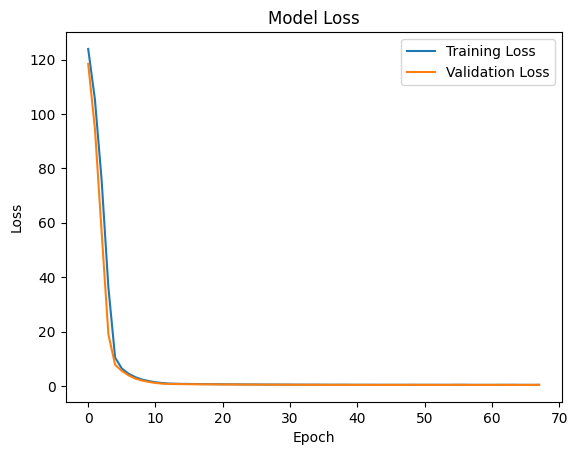

In [13]:
train_model = False

if train_model:
    # Train the model
    history = model.fit(X_train, y_train, epochs=250, batch_size=batch_size, verbose=2, validation_split=0.2, callbacks=[early_stopping])
    


    # Plot training history
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
else:
    from keras.saving import load_model
    model = load_model(f'model/{model_name}.keras')

In [14]:
save_model = False

if save_model and train_model:
    model.save(f'model/{model_name}.keras')

In [15]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 4ms/step - loss: 0.5573


0.5572896003723145

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(X_test)

# Calculating MSE and MAE for Linear Regression Model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Calculating RMSE for both models
rmse = np.sqrt(mse)

# Printing the results
print("Test Split")
print("-----------")
print("MSE:", mse)
print("MAE:", mae)
print("RMSE:", rmse)
print("-----------")

y_pred = model.predict(features)

mse = mean_squared_error(targets, y_pred)
mae = mean_absolute_error(targets, y_pred)
rmse = np.sqrt(mse)

print("Total")
print("-----------")
print("MSE:", mse)
print("MAE:", mae)
print("RMSE:", rmse)
print("-----------")

4/4 [==============================] - 0s 2ms/step
Test Split
-----------
MSE: 0.5572894582142958
MAE: 0.5948265821626871
RMSE: 0.7465182236317448
-----------
16/16 [==============================] - 0s 2ms/step
Total
-----------
MSE: 0.45418806052892313
MAE: 0.5475951198547606
RMSE: 0.6739347598461761
-----------


In [19]:
robot_speed_test = np.arange(8,29)
layer_height_test = np.repeat(5, robot_speed_test.shape[0])
layer_width_test = np.repeat(8, robot_speed_test.shape[0])

test_data = pd.DataFrame({
    'robot_speed': robot_speed_test,
    'layer_height': layer_height_test,
    'layer_width': layer_width_test
})

In [20]:
save_test = False

test_scaled = feature_scaler.transform(test_data)

pred_extrusion_speed = model.predict(test_scaled)
test_data["do_prediction"] = np.round((pred_extrusion_speed-6)*10)
test_data["rpm_prediction"] = pred_extrusion_speed

if save_test:
    test_data.to_csv(f'validation_{model_name}.csv', index=False)

test_data

1/1 [==============================] - 0s 22ms/step


,robot_speed,layer_height,layer_width,do_prediction,rpm_prediction
0,8,5,8,11.0,7.092092
1,9,5,8,15.0,7.533902
2,10,5,8,19.0,7.930395
3,11,5,8,23.0,8.326889
4,12,5,8,27.0,8.723440
5,13,5,8,31.0,9.105018
6,14,5,8,34.0,9.443975
7,15,5,8,38.0,9.774992
8,16,5,8,41.0,10.100541
9,17,5,8,44.0,10.426092
